In [1]:
import sys
sys.path.insert(0, "..")

import torch
import numpy as np
import torch.nn as nn
from tqdm import trange
import torch.nn.functional as F
import matplotlib.pyplot as plt

from edunets import functional, losses
from edunets.tensor import Tensor

### Basic Cross-correlation

Let's make sure the cross correlation works

In [2]:
a = np.array([
    [1., 2., 3.],
    [4., 5., 6.],
    [7., 8., 9.]
])
v = np.array([
    [2., 3.],
    [3., 2.]
])

In [3]:
# Pytorch only supports 3 dimentional vectors for F.conv so we add dummy dimensions
x = torch.tensor(a, dtype=float)[None, None]
w = torch.tensor(v, dtype=float)[None, None]
F.conv2d(x, w)

tensor([[[[30., 40.],
          [60., 70.]]]], dtype=torch.float64)

In [4]:
Tensor(a).correlate(v)

tensor([[30., 40.],
       [60., 70.]], dtype=float32)

Now let's see if the gradients match

In [5]:
x = torch.tensor(a[None, None], dtype=float, requires_grad=True)
w = torch.tensor(v[None, None], dtype=float, requires_grad=True)
out = F.conv2d(x, w)
print(out)
out.backward(torch.ones(out.shape))

print(x.grad)
print(w.grad)

tensor([[[[30., 40.],
          [60., 70.]]]], dtype=torch.float64, grad_fn=<ThnnConv2DBackward>)
tensor([[[[ 2.,  5.,  3.],
          [ 5., 10.,  5.],
          [ 3.,  5.,  2.]]]], dtype=torch.float64)
tensor([[[[12., 16.],
          [24., 28.]]]], dtype=torch.float64)


In [6]:
x = Tensor(a[None, None], requires_grad=True)
w = Tensor(v[None, None], requires_grad=True)
out = x.correlate(w)
print(out)
out.backward(Tensor.ones(*out.shape))

print(x.grad)
print(w.grad)

tensor([[[[30., 40.],
         [60., 70.]]]], dtype=float32)
[[[[ 2.  5.  3.]
   [ 5. 10.  5.]
   [ 3.  5.  2.]]]]
[[[[12. 16.]
   [24. 28.]]]]


They do yay! Now we have to try and add the other paramaters that are in torch's cond1d, like padding and stride.

### Cross-correlation with extra paramaters

Let's start with stride, meaning how much the kernel shifts when performing cross-correlation. Default is 1, so the kernel just slides naturaly accross the input. 

With stride = 1, we get, for input=[1,2,3,4,5,6] and kernel=[6,7]:

6*1 + 7*2 = 20

6*2 + 7*3 = 33


...

6*4 + 7*5 = 59

so the convolution is [20, 33, 46, 59]

With stride = 2 we just take the index that are equal to 0 modulo 2
this of course generelizes to any value of stride

In [7]:
stride = 2

x = torch.tensor(a[None, None], dtype=float, requires_grad=True)
w = torch.tensor(v[None, None], dtype=float, requires_grad=True)
out = F.conv1d(x, w, stride=stride)
print(out)
out.backward(torch.ones(out.shape))

print(x.grad)
print(w.grad)

tensor([[[[30.]]]], dtype=torch.float64, grad_fn=<ThnnConv2DBackward>)
tensor([[[[2., 3., 0.],
          [3., 2., 0.],
          [0., 0., 0.]]]], dtype=torch.float64)
tensor([[[[1., 2.],
          [4., 5.]]]], dtype=torch.float64)


tensor([[[[30.]]]], dtype=float32)
[[[[0. 0. 0.]
   [0. 2. 3.]
   [0. 3. 2.]]]]
[[[[1. 2.]
   [4. 5.]]]]


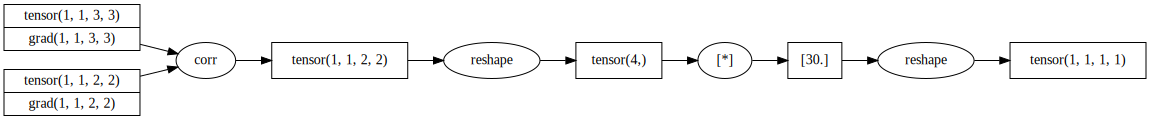

In [9]:
x = Tensor(a[None, None], dtype=float, requires_grad=True)
w = Tensor(v[None, None], dtype=float, requires_grad=True)
out = x.correlate(w)

# selecting base on stride
idx = tuple(i for i in range(x.shape[-1] - 1) if i % stride == 0)
out = out.reshape((-1,))[idx].reshape(tuple(1 for _ in range(len(out.shape))))

print(out)
out.backward(Tensor.ones(*out.shape))

print(x.grad)
print(w.grad)
out.graph

### Convolution Layer

The first step is to implement a convolution layer class

In [ ]:
class Conv2d:
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input.shape
        
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        
        self.kernels = Tensor.uniform(*self.kernels_shape)
        self.biases = Tensor.uniform(*self.output_shape)

    def forward(self, x):
        output = self.biases.copy()

        for i in range(self.depth):
            for j in range(self.input_depth):
                output[i] = output[i] + x[j].correlate(self.kernels[i,j], mode="valid")